In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os
import re
import nltk

In [4]:
reviews_train = []
for line in open('c:/Users/Engit/Desktop/bitirme_projesi/movie_data/full_train.txt','r',encoding='utf8'):
    
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('C:/Users/Engit/Desktop/bitirme_projesi/movie_data/full_test.txt','r',encoding='utf8'):
    
    reviews_test.append(line.strip())

In [5]:
reviews_train[5]

"This isn't the comedic Robin Williams, nor is it the quirky/insane Robin Williams of recent thriller fame. This is a hybrid of the classic drama without over-dramatization, mixed with Robin's new love of the thriller. But this isn't a thriller, per se. This is more a mystery/suspense vehicle through which Williams attempts to locate a sick boy and his keeper.<br /><br />Also starring Sandra Oh and Rory Culkin, this Suspense Drama plays pretty much like a news report, until William's character gets close to achieving his goal.<br /><br />I must say that I was highly entertained, though this movie fails to teach, guide, inspect, or amuse. It felt more like I was watching a guy (Williams), as he was actually performing the actions, from a third person perspective. In other words, it felt real, and I was able to subscribe to the premise of the story.<br /><br />All in all, it's worth a watch, though it's definitely not Friday/Saturday night fare.<br /><br />It rates a 7.7/10 from...<br />

In [6]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

In [7]:
reviews_train_clean[5]

'this isnt the comedic robin williams nor is it the quirky insane robin williams of recent thriller fame this is a hybrid of the classic drama without over dramatization mixed with robins new love of the thriller but this isnt a thriller per se this is more a mystery suspense vehicle through which williams attempts to locate a sick boy and his keeper also starring sandra oh and rory culkin this suspense drama plays pretty much like a news report until williams character gets close to achieving his goal i must say that i was highly entertained though this movie fails to teach guide inspect or amuse it felt more like i was watching a guy williams as he was actually performing the actions from a third person perspective in other words it felt real and i was able to subscribe to the premise of the story all in all its worth a watch though its definitely not friday saturday night fare it rates a   from the fiend '

# BaseLine

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

target = [1 if i < 12500 else 0 for i in range(25000)]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

C:\Users\Engit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.88128
Accuracy for C=0.05: 0.88592
Accuracy for C=0.25: 0.8816
Accuracy for C=0.5: 0.87776
Accuracy for C=1: 0.87504


In [10]:
final_model = LogisticRegression(C=0.05)
final_model.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_model.predict(X_test)))

Final Accuracy: 0.88128


In [11]:
final_model = LogisticRegression(C=0.25)
final_model.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_model.predict(X_test)))

Final Accuracy: 0.8768


In [12]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
#     ('excellent', 0.9288812418118644)
#     ('perfect', 0.7934641227980576)
#     ('great', 0.675040909917553)
#     ('amazing', 0.6160398142631545)
#     ('superb', 0.6063967799425831)
print("--------------------------------------------")
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)
    
#     ('worst', -1.367978497228895)
#     ('waste', -1.1684451288279047)
#     ('awful', -1.0277001734353677)
#     ('poorly', -0.8748317895742782)
#     ('boring', -0.8587249740682945)

('excellent', 1.214118989137929)
('perfect', 1.0614176588850035)
('refreshing', 1.02102897303396)
('superb', 0.9475637842873753)
('wonderfully', 0.9340347499483456)
--------------------------------------------
('worst', -1.8263539438928587)
('waste', -1.6781628000922757)
('disappointment', -1.406995848590213)
('poorly', -1.4016882951821332)
('awful', -1.3764772758952484)


## Removing STOP words

In [13]:
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

no_stop_words_train = remove_stop_words(reviews_train_clean)
no_stop_words_test = remove_stop_words(reviews_test_clean)

cv = CountVectorizer(binary=True)
cv.fit(no_stop_words_train)
X = cv.transform(no_stop_words_train)
X_test = cv.transform(no_stop_words_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

C:\Users\Engit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.87216
Accuracy for C=0.05: 0.87856
Accuracy for C=0.25: 0.8744
Accuracy for C=0.5: 0.8736
Accuracy for C=1: 0.87088


# Stemming

In [14]:
def get_stemmed_text(corpus):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

stemmed_reviews_train = get_stemmed_text(reviews_train_clean)
stemmed_reviews_test = get_stemmed_text(reviews_test_clean)

cv = CountVectorizer(binary=True)
cv.fit(stemmed_reviews_train)
X = cv.transform(stemmed_reviews_train)
X_test = cv.transform(stemmed_reviews_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_stemmed = LogisticRegression(C=0.05)
final_stemmed.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_stemmed.predict(X_test)))

C:\Users\Engit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.87104
Accuracy for C=0.05: 0.88016
Accuracy for C=0.25: 0.87936
Accuracy for C=0.5: 0.87584
Accuracy for C=1: 0.87472
Final Accuracy: 0.87736


# Lemmatization

In [15]:
def get_lemmatized_text(corpus):
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

lemmatized_reviews_train = get_lemmatized_text(reviews_train_clean)
lemmatized_reviews_test = get_lemmatized_text(reviews_test_clean)

cv = CountVectorizer(binary=True)
cv.fit(lemmatized_reviews_train)
X = cv.transform(lemmatized_reviews_train)
X_test = cv.transform(lemmatized_reviews_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_lemmatized = LogisticRegression(C=0.25)
final_lemmatized.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_lemmatized.predict(X_test)))

C:\Users\Engit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.87408
Accuracy for C=0.05: 0.88352
Accuracy for C=0.25: 0.8824
Accuracy for C=0.5: 0.87952
Accuracy for C=1: 0.87552
Final Accuracy: 0.87376


# Removed stop words

In [16]:
no_stop_words_train[5]

'isnt comedic robin williams quirky insane robin williams recent thriller fame hybrid classic drama without dramatization mixed robins new love thriller isnt thriller per se mystery suspense vehicle williams attempts locate sick boy keeper also starring sandra oh rory culkin suspense drama plays pretty much like news report williams character gets close achieving goal must say highly entertained though movie fails teach guide inspect amuse felt like watching guy williams actually performing actions third person perspective words felt real able subscribe premise story worth watch though definitely friday saturday night fare rates fiend'

# Stemmed

In [17]:
stemmed_reviews_train[5]

'thi isnt the comed robin william nor is it the quirki insan robin william of recent thriller fame thi is a hybrid of the classic drama without over dramat mix with robin new love of the thriller but thi isnt a thriller per se thi is more a mysteri suspens vehicl through which william attempt to locat a sick boy and hi keeper also star sandra oh and rori culkin thi suspens drama play pretti much like a news report until william charact get close to achiev hi goal i must say that i wa highli entertain though thi movi fail to teach guid inspect or amus it felt more like i wa watch a guy william as he wa actual perform the action from a third person perspect in other word it felt real and i wa abl to subscrib to the premis of the stori all in all it worth a watch though it definit not friday saturday night fare it rate a from the fiend'

# Lemmatized

In [18]:
lemmatized_reviews_train[5]

'this isnt the comedic robin williams nor is it the quirky insane robin williams of recent thriller fame this is a hybrid of the classic drama without over dramatization mixed with robin new love of the thriller but this isnt a thriller per se this is more a mystery suspense vehicle through which williams attempt to locate a sick boy and his keeper also starring sandra oh and rory culkin this suspense drama play pretty much like a news report until williams character get close to achieving his goal i must say that i wa highly entertained though this movie fails to teach guide inspect or amuse it felt more like i wa watching a guy williams a he wa actually performing the action from a third person perspective in other word it felt real and i wa able to subscribe to the premise of the story all in all it worth a watch though it definitely not friday saturday night fare it rate a from the fiend'

# N-grams

In [19]:
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
# Accuracy for C=0.01: 0.88416
# Accuracy for C=0.05: 0.892
# Accuracy for C=0.25: 0.89424
# Accuracy for C=0.5: 0.89456
# Accuracy for C=1: 0.8944
    
final_ngram = LogisticRegression(C=0.5)
final_ngram.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_ngram.predict(X_test)))

C:\Users\Engit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.88416
Accuracy for C=0.05: 0.88864
Accuracy for C=0.25: 0.8912
Accuracy for C=0.5: 0.89056
Accuracy for C=1: 0.88944
Final Accuracy: 0.89872


# word counts

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

wc_vectorizer = CountVectorizer(binary=False)
wc_vectorizer.fit(reviews_train_clean)
X = wc_vectorizer.transform(reviews_train_clean)
X_test = wc_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75, 
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
# Accuracy for C=0.01: 0.87456
# Accuracy for C=0.05: 0.88016
# Accuracy for C=0.25: 0.87936
# Accuracy for C=0.5: 0.87936
# Accuracy for C=1: 0.87696
    
final_wc = LogisticRegression(C=0.05)
final_wc.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_wc.predict(X_test)))


C:\Users\Engit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.87888
Accuracy for C=0.05: 0.88896
Accuracy for C=0.25: 0.88928
Accuracy for C=0.5: 0.88576
Accuracy for C=1: 0.88176
Final Accuracy: 0.882


# TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(reviews_train_clean)
X = tfidf_vectorizer.transform(reviews_train_clean)
X_test = tfidf_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

# Accuracy for C=0.01: 0.79632
# Accuracy for C=0.05: 0.83168
# Accuracy for C=0.25: 0.86768
# Accuracy for C=0.5: 0.8736
# Accuracy for C=1: 0.88432
    
final_tfidf = LogisticRegression(C=1)
final_tfidf.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_tfidf.predict(X_test)))

C:\Users\Engit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.79056
Accuracy for C=0.05: 0.824
Accuracy for C=0.25: 0.8632
Accuracy for C=0.5: 0.87216
Accuracy for C=1: 0.87968
Final Accuracy: 0.88248


# Support Vector Machines(SVM)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    
# Accuracy for C=0.01: 0.89104
# Accuracy for C=0.05: 0.88736
# Accuracy for C=0.25: 0.8856
# Accuracy for C=0.5: 0.88608
# Accuracy for C=1: 0.88592
    
final_svm_ngram = LinearSVC(C=0.01)
final_svm_ngram.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_svm_ngram.predict(X_test)))

C:\Users\Engit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.89296
Accuracy for C=0.05: 0.88864
Accuracy for C=0.25: 0.88704
Accuracy for C=0.5: 0.88672
Accuracy for C=1: 0.88608
Final Accuracy: 0.8976


# Final Model

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC


stop_words = ['in', 'of', 'at', 'a', 'the']
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    
# Accuracy for C=0.001: 0.88784
# Accuracy for C=0.005: 0.89456
# Accuracy for C=0.01: 0.89376
# Accuracy for C=0.05: 0.89264
# Accuracy for C=0.1: 0.8928
    
final = LinearSVC(C=0.01)
final.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final.predict(X_test)))

C:\Users\Engit\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.001: 0.88672
Accuracy for C=0.005: 0.89264
Accuracy for C=0.01: 0.89216
Accuracy for C=0.05: 0.89088
Accuracy for C=0.1: 0.89072
Final Accuracy: 0.9


# Best Positive and Negative features

In [24]:
feature_to_coef = {
    word: coef for word, coef in zip(
        ngram_vectorizer.get_feature_names(), final.coef_[0]
    )
}

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:100]:
    print (best_positive)
    
print("\n\n")
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:100]:
    print (best_negative)

('excellent', 0.23047714665295013)
('perfect', 0.18507025635085939)
('great', 0.17881800966482828)
('wonderful', 0.1607892596271847)
('amazing', 0.15226950252500274)
('superb', 0.14695922772180878)
('enjoyable', 0.14431473750335974)
('best', 0.13064244558670104)
('enjoyed', 0.12732762211231663)
('fun', 0.12671723549565903)
('today', 0.1218357629667757)
('brilliant', 0.12065189507849217)
('must see', 0.117547369049201)
('fantastic', 0.11538150899949517)
('loved', 0.11334099469542266)
('liked', 0.11200563742048612)
('funniest', 0.11168721821511732)
('incredible', 0.10863100732595118)
('wonderfully', 0.10755457353594858)
('better than', 0.10678238074676964)
('rare', 0.1040181340090769)
('beautiful', 0.1036376996614285)
('bit', 0.10192527260339772)
('love', 0.10181871499151712)
('well worth', 0.10117934903435798)
('highly', 0.10095355710540657)
('job', 0.10068804342180443)
('watch it', 0.09981112018055724)
('recommended', 0.09814962678181723)
('moving', 0.09695428184817509)
('perfectly', 0

In [63]:
import pickle
clf = LinearSVC().fit(X_train, y_train)
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [39]:
result = loaded_model.predict(ngram_vectorizer.transform([lemmatized_reviews_test[11800]]))
print (result)

[1]


In [62]:
result = loaded_model.predict(ngram_vectorizer.transform(["still"]))
print (result)

[1]


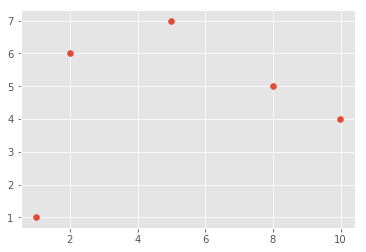

In [36]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
xx=[1,2,5,8,9.98]
yy=[1,6,7,5,4]
plt.scatter(xx, yy)
plt.show()